In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import tes_analysis_tools as tat
import sklearn
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.distribution import MultiprocessingDistributor
sns.set()

In [2]:
dir = "../WF/exp1/"
savedir = "./exp1_result/"
pulse = np.load(dir + "pulse.npy")
noise = np.load(dir + "noise.npy")
time  = np.load(dir + "time.npy")

n  = pulse.shape[0]
dp = pulse.shape[1]
m  = noise.shape[0]
dt = time[1] - time[0]

# baseline 補正, 先頭からdpbl点の平均をoffsetとして引き去る
dpbl = 200
pulse = tat.correct_baseline(pulse, dpbl)

# 正負反転
pulse = -1.0 * pulse

# Utils

## 波形のノイズ除去のための回帰処理

In [3]:
def regression(data):
    fit = np.polyfit(time, data, 18)
    fit_fn = np.poly1d(fit)
    return fit_fn(time)

def plot_regression_curve(x, y, n=18):
    fit = np.polyfit(x, y, n)
    fit_fn = np.poly1d(fit)
    plt.plot(x, y, label="data")
    plt.plot(x, fit_fn(x), label="regression")
    plt.legend()
    plt.show()

# クラスタリング

In [4]:
df = pd.DataFrame(pulse)
df.index.name = "id"
df_corrected = df.apply(regression, axis=1, result_type="expand")
# 主成分分析
pca_model = PCA(n_components=2)
X_pca = pca_model.fit_transform(df_corrected.values)
pca_df = pd.DataFrame(data=X_pca, index=df_corrected.index, columns=["first_component", "second_component"])

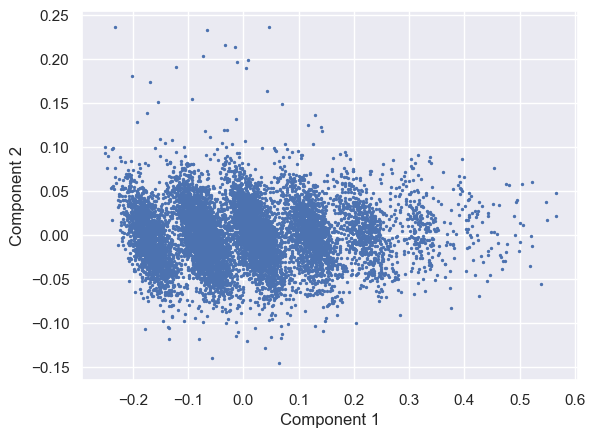

In [5]:
plt.scatter(pca_df["first_component"], pca_df["second_component"], s=2)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [6]:
# K-Means
kmeans_model = KMeans(n_clusters=6)
y_pred_kmeans = kmeans_model.fit_predict(pca_df.values)

# DBSCAN
dbscan_model = DBSCAN(eps=0.014, min_samples=100)
y_pred_dbscan = dbscan_model.fit_predict(pca_df.values)

pca_df["kmeans_pred"] = y_pred_kmeans
pca_df["dbscan_pred"] = y_pred_dbscan

c:\Users\keisu\UTokyo\RyoikiProject\PhotonClustering\photon_clustering_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
# 第一主成分の平均値が低いクラスタから0, 1, ...と再ラベリング
def relabel_by_first_comonent_avg(label_col, pca_df):
    relabeled_pca_df = pca_df.copy()
    first_component_avg_per_cluster = {}
    for label in set(pca_df[label_col]):
        if label != -1:
            first_component_avg_per_cluster[label] = pca_df[pca_df[label_col]==label]["first_component"].mean() 
    sorted_keys = sorted(first_component_avg_per_cluster, key=lambda x: first_component_avg_per_cluster[x])
    relabel_dict = {k: v for v, k in enumerate(sorted_keys)}
    relabel_dict[-1] = -1
    relabeled_pca_df[label_col] = relabeled_pca_df[label_col].map(relabel_dict)
    return relabeled_pca_df

pca_df = relabel_by_first_comonent_avg("kmeans_pred", pca_df)
pca_df = relabel_by_first_comonent_avg("dbscan_pred", pca_df)

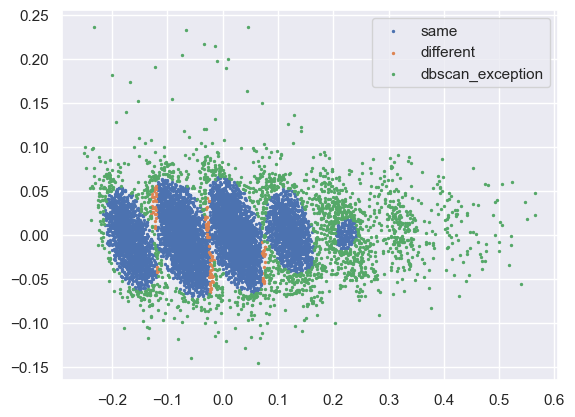

In [8]:
# K-MeansとDBSCANで予測が同じもの、異なるものを確認
same_pred = pca_df[pca_df["kmeans_pred"]==pca_df["dbscan_pred"]]
different_pred = pca_df[(pca_df["dbscan_pred"] != pca_df["kmeans_pred"]) & (pca_df["dbscan_pred"] != -1)]
dbscan_exception = pca_df[pca_df["dbscan_pred"]==-1]
plt.scatter(same_pred["first_component"], same_pred["second_component"], s=2, label="same")
plt.scatter(different_pred["first_component"], different_pred["second_component"], s=2, label="different")
plt.scatter(dbscan_exception["first_component"], dbscan_exception["second_component"], s=2, label="dbscan_exception")
plt.legend()
plt.show()

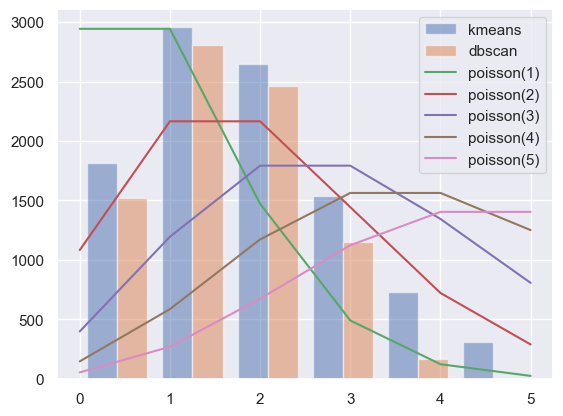

In [9]:
# クラスタのヒストグラムがpoisson分布に従っているか確認
def poisson(x, lam=1):
    return 8000 * (np.e ** (-lam)) * (lam ** x) / math.factorial(x)
x_list = np.arange(0, 6)
lam_list = range(1,6)
y_list_per_lam = {lam: [poisson(x, lam) for x in x_list] for lam in lam_list}

plt.hist([pca_df["kmeans_pred"], pca_df[pca_df["dbscan_pred"]!=-1]["dbscan_pred"]], bins=6, alpha=0.5, label=["kmeans", "dbscan"])
for lam in lam_list:
    plt.plot(x_list, y_list_per_lam[lam], label=f"poisson({lam})")
plt.legend()
plt.show()

# 最適フィルタリング

In [ ]:
# 波形整形
pulse = tat.shaping(pulse, dt, 1.0e-6, 1.0e-6, True)

# 平均波形
avg = tat.make_average_pulse(pulse, 0.0, 1.0, 200, 500, True, True, True)

# 単純波高値
tat.simple_ph_spectrum(pulse, 200, 500, True, True)

# 最適フィルタ
ph, hist = tat.optimal_filter_freq(pulse, avg, noise, dt, 1.0e6, False, True)

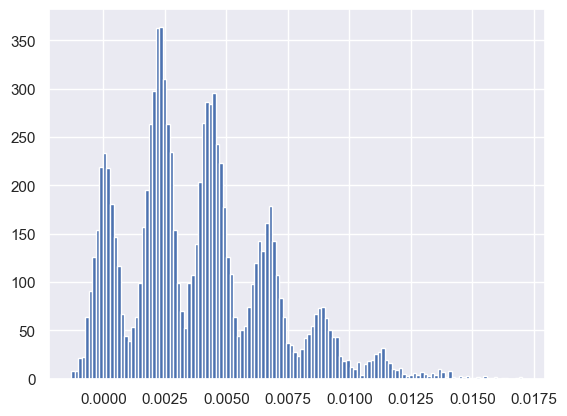

In [11]:
plt.hist(ph, bins=128)
plt.show()

In [12]:
df_optimal_filtered = pd.DataFrame(pulse)
df_optimal_filtered.index.name = "id"
df_optimal_filtered["ph"] = ph

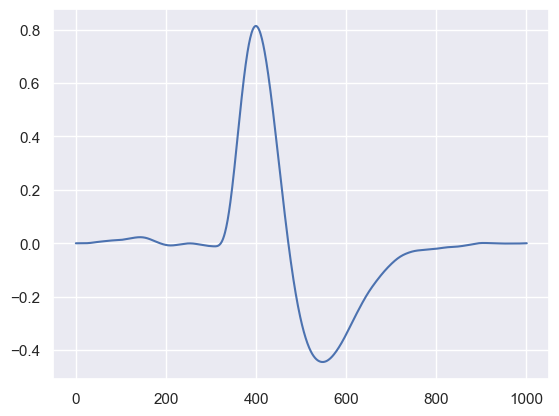

In [13]:
plt.plot(avg)

0.005264612144655195


<Axes: >

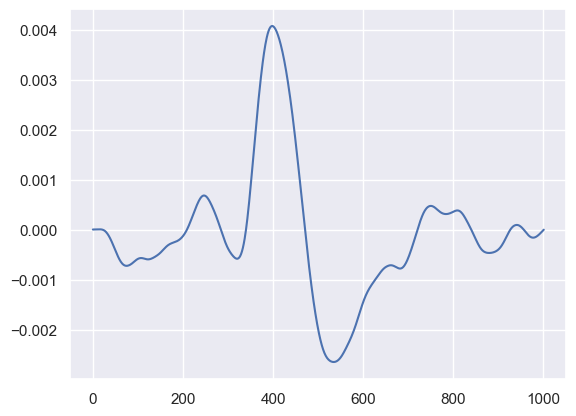

In [14]:
print(df_optimal_filtered.iloc[0, -1])
df_optimal_filtered.iloc[0, :-1].plot()

In [15]:
df_optimal_filtered

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,1000,1001,ph
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,3.134007e-09,1.805780e-08,5.442920e-08,1.224698e-07,2.357330e-07,4.069212e-07,6.446123e-07,9.539026e-07,1.333842e-06,...,-0.000079,-0.000070,-0.000060,-0.000051,-0.000041,-0.000032,-0.000022,-0.000013,-0.000004,0.005265
1,0.0,-6.267955e-09,-3.298141e-08,-1.033361e-07,-2.470705e-07,-4.983598e-07,-8.877694e-07,-1.445393e-06,-2.197016e-06,-3.167439e-06,...,-0.000246,-0.000256,-0.000266,-0.000275,-0.000284,-0.000292,-0.000299,-0.000306,-0.000313,0.000301
2,0.0,-3.133958e-09,-8.655644e-09,-1.592544e-08,-1.813052e-08,-1.003448e-08,1.537955e-08,6.636098e-08,1.487941e-07,2.665553e-07,...,0.000636,0.000649,0.000661,0.000671,0.000681,0.000689,0.000695,0.000701,0.000705,-0.000218
3,0.0,6.267969e-09,2.984747e-08,7.587655e-08,1.510046e-07,2.660310e-07,4.378756e-07,6.815759e-07,1.013440e-06,1.447207e-06,...,-0.000227,-0.000236,-0.000246,-0.000255,-0.000263,-0.000270,-0.000277,-0.000283,-0.000288,0.006282
4,0.0,0.000000e+00,0.000000e+00,3.133982e-09,1.492372e-08,4.263921e-08,8.848585e-08,1.506360e-07,2.147199e-07,2.662348e-07,...,0.000399,0.000400,0.000401,0.000402,0.000404,0.000406,0.000409,0.000412,0.000415,0.000622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,-3.133958e-09,-1.805762e-08,-5.756272e-08,-1.342586e-07,-2.634468e-07,-4.684349e-07,-7.719747e-07,-1.192673e-06,-1.742243e-06,...,-0.000036,-0.000032,-0.000029,-0.000025,-0.000022,-0.000019,-0.000015,-0.000012,-0.000009,0.002189
9996,0.0,6.267964e-09,3.298146e-08,9.393426e-08,2.085675e-07,3.908881e-07,6.471499e-07,9.804570e-07,1.394429e-06,1.896059e-06,...,0.000064,0.000069,0.000074,0.000078,0.000080,0.000081,0.000081,0.000079,0.000076,0.002253
9997,0.0,0.000000e+00,6.267964e-09,3.298141e-08,9.393407e-08,2.054331e-07,3.979013e-07,7.183772e-07,1.225813e-06,1.996481e-06,...,0.000524,0.000523,0.000520,0.000517,0.000513,0.000508,0.000502,0.000495,0.000488,0.006011
